In [188]:
import random

#random.seed(42)

def create_graph(cols=10, max_height=20):
    """Create a random bar chart of width 1, and length cols."""
    height = [random.randint(0,max_height) for i in range(cols)]
    width = [1 for i in range(cols)]
    area = [height[i] * width[i] for i in range(cols)]
    
    return list(zip(height, width, area))

def compress(graph, start_pos, count):
    """For the subset of graphs, find the min height and multuple by the sum of the widths"""
    graph_subset = graph[start_pos:start_pos+count+1]
    #print("graph_subset: " +  str(graph_subset))
    smallest = None
    width = 0
    for tup in graph_subset:
        h, w, a = tup[0:3]
        if smallest is None:
            smallest = h
        elif h < smallest:
            smallest = h
        if smallest == 0:
            #print("smallest:" + str(smallest))
            return (smallest, width, smallest*width)
        width += w
    #print("smallest:" + str(smallest))
    return (smallest, width, smallest*width)

def find_max(graph):
    """
    Brute force algorithm to find the biggest rectangle in a graph.
    From every position check the next positions, and calculate
    the maximum area using compress(). Stop if this hits zero.
    Then at the end, pick the biggest volume from the run.
    Move to the next index and repeat.
    
    It's time O(N^3) - or at best O(N^2.logN), space O(N).
    """
    loop_max = []
    size = len(graph)
    for start in range(size):
        largest = 0
        end = size - start
        #print("start: " + str(start))
        #print("end: " + str(end))
        for count in range(end):
            tup = compress(graph, start, count)
            area = tup[0] * tup[1]
            #print("area: " + str(area))
            if area == 0:
                break
            elif area > largest:
                largest = area
        loop_max.append(largest)
    return max(loop_max)

graph = create_graph(cols=5, max_height=5)
print(find_max(graph))
#print(graph)

6


Let's create some unit tests:

In [187]:
import unittest

class TestGraph(unittest.TestCase):
        
    def test_all_zero(self):
        height = [0] * 10
        width  = [1] * 10
        area   = [0] * 10
        graph  = list(zip(height, width, area))
        self.assertEqual(find_max(graph), 0)

    def test_all_1(self):
        height = [1] * 10
        width  = [1] * 10
        area   = [1] * 10
        graph  = list(zip(height, width, area))
        self.assertEqual(find_max(graph), 10)
        
    def test_alternating_10(self):
        height = [10, 0] * 5
        width  = [1] * 10
        area   = [height[i] * width[i] for i in range(10)]
        graph  = list(zip(height, width, area))
        self.assertEqual(find_max(graph), 10)
        
    def test_staircase_up_10(self):
        height = list(range(11))
        width  = [1] * 10
        area   = [height[i] * width[i] for i in range(10)]
        graph  = list(zip(height, width, area))
        self.assertEqual(find_max(graph), 25)

    def test_staircase_down_10(self):
        height = list(range(9, -1, -1))
        width  = [1] * 10
        area   = [height[i] * width[i] for i in range(10)]
        graph  = list(zip(height, width, area))
        self.assertEqual(find_max(graph), 25)
        
    def test_teeth_10(self):
        height = [0,10,10,0,21,0,5,6,6,5]
        width  = [1] * 10
        area   = [height[i] * width[i] for i in range(10)]
        graph  = list(zip(height, width, area))
        self.assertEqual(find_max(graph), 21)

    def test_pyramid_10(self):
        height = [0,1,2,3,4,4,3,2,1,0]
        width  = [1] * 10
        area   = [height[i] * width[i] for i in range(10)]
        graph  = list(zip(height, width, area))
        self.assertEqual(find_max(graph), 12)

    def test_flipped_pyramid_10(self):
        height = [4,3,2,1,0,0,1,2,3,4]
        width  = [1] * 10
        area   = [height[i] * width[i] for i in range(10)]
        graph  = list(zip(height, width, area))
        self.assertEqual(find_max(graph), 6)
        
    def test_tall_and_flat_10(self):
        height = [10,0,0,0,0,2,2,2,2,2]
        width  = [1] * 10
        area   = [height[i] * width[i] for i in range(10)]
        graph  = list(zip(height, width, area))
        self.assertEqual(find_max(graph), 10)
        
    def test_sawtooth_10(self):
        height = [3,9,18,9,3,9,18,9,3,9]
        width  = [1] * 10
        area   = [height[i] * width[i] for i in range(10)]
        graph  = list(zip(height, width, area))
        self.assertEqual(find_max(graph), 30)
    

a = TestGraph()
suite = unittest.TestLoader().loadTestsFromModule(a)
unittest.TextTestRunner().run(suite)

..........
----------------------------------------------------------------------
Ran 10 tests in 0.034s

OK


<unittest.runner.TextTestResult run=10 errors=0 failures=0>

## Improvement Two

A more efficient algorithm takes advantage of commutation. I can replace [3,6,3] with [3,3,3]. or 3 with a width 3.

Find chunks we can compress. Then replace those entries with a single entry. e.g.
```
[2, 2, 0, 4, 5]
[1, 1, 1, 1, 1]
[2, 2, 0, 4, 5]
```

Compress the first two:
```
[2, 0, 4, 5]
[2, 1, 1, 1]
[4, 1, 4, 5]
```

Compress the last two:
```
[2, 0, 4]
[2, 1, 2]
[4, 0, 8]
```

No more compressions possible, pick the largest value:
```
[4]
[2]
[8]
```

This problem is a sorting problem with structure - I've heard of, but not used, topographical search: Could that fit?

I've modified compress() to return a common minimum graph element for a given subset. It stops searching at any zero, and it will not find the biggest rectangle - that's the responsibility of the caller to feed it interesting subsets and pick the best one to replace.

Hmm - I still can't see this improving O(N^2.logN) - there is still the all 1's scenario. 

What if I create a new graph, which is the change from the last position - are there any patterns there?

[2, 0, 2, 1, -2, 2, 0, -4, 2, -2]


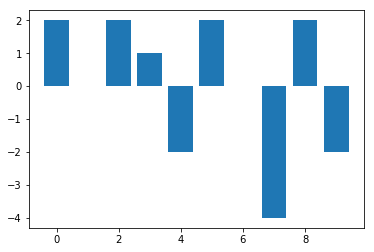

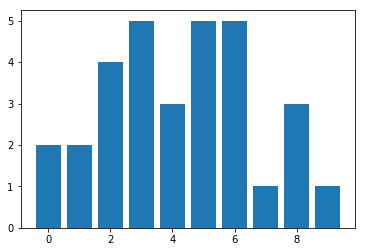

In [202]:
# Explore the delta in height - any useful patterns?
def h_delta(graph):
    last = 0
    diff = []
    for tup in graph:
        diff.append(tup[0] - last)
        last = tup[0]
    return diff
        
graph = create_graph(cols=10, max_height=5)
d = h_delta(graph)
print(d)

import matplotlib.pyplot as plt
plt.bar(list(range(10)), d)
plt.show()
plt.bar(list(range(10)), [tup[0] for tup in graph])
plt.show()

The delta is not useful.